# customer Segmentation

Use jupyter notebook to conduct interactive data analysis.

Also output crucial files for data visualization on web.

In [28]:
import numpy as np
import pandas as pd
import json
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

# json encoder for numpy
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return None if math.isnan(obj) else float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
    
# Define a function to remove HTML tags from a string
def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped = soup.get_text(separator=" ")
    return stripped

COMMENT_SAMPLE_N = 10
CLUSTER_NUM = 6
POINTS_EACH_CLUSTER = 1000

customer_csv_path = '../data/csv/aug_customers.csv'
product_csv_path = '../data/csv/aug_products.csv'
comment_csv_path = '../data/csv/aug_comments.csv'

output_base_dir = '../stats/customer'

In [2]:
# parse selected comments to json form
# and join info from products & customers
def parse_joined_comments_to_json(selected_comment_df):
    comments = []
    for idx, comment_ds in selected_comment_df.iterrows():
        comment = {
            'summary': None if isinstance(comment_ds['summary'], float) and math.isnan(comment_ds['summary']) else comment_ds['summary'],
            'review': comment_ds['review'],
            'timestamp': comment_ds['timestamp'],
            'rating': comment_ds['overall'],
            'sentiment': comment_ds['sentiment'],
            'overall': comment_ds['sentimentWithRating'],
            'wordCount': comment_ds['wordCount'],
        }
        customer_ds = customer_df[customer_df['customerId']==comment_ds['customerId']].iloc[0]
        product_ds = product_df[product_df['asin']==comment_ds['asin']].iloc[0]
        comment['customer'] = {
            'customerId': customer_ds['customerId'],
            'name': customer_ds['name'],
            'cluster': customer_ds['cluster'],
        }
        comment['product'] = {
            'asin': product_ds['asin'],
            'title': product_ds['title'],
            'brand': None if isinstance(product_ds['brand'], float) and math.isnan(product_ds['brand']) else product_ds['brand'],
            # 'imageUrl': product_ds['imageUrl'],
            'imageUrl': None if isinstance(product_ds['imageUrl'], float) and math.isnan(product_ds['imageUrl']) else product_ds['imageUrl'],
            'price': product_ds['price'],
            'categories': product_ds['categories'].split(','),
            'avgRating': product_ds['avgOverall'],
            'avgSentiment': product_ds['avgSentiment'],
            'avgOverall': product_ds['avgSentimentWithRating'],
            'reviewCount': product_ds['reviewCount'],
        }
        comments.append(comment)
    return comments

## Load Data

In [3]:
product_df = pd.read_csv(product_csv_path)

/tmp/ipykernel_67943/201748605.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  product_df = pd.read_csv(product_csv_path)


Number of products: 181839


In [6]:
product_df = product_df[product_df['reviewCount'] > 0]

product_df.head()


,asin,title,brand,description,imageUrl,rank,price,categories,avgOverall,avgSentiment,avgSentimentWithRating,reviewCount
0,0000695009,Understanding Seizures and Epilepsy,NaN,NaN,NaN,886503,-1.00,Movies,4.00,-0.106250,6.234375,1
1,0000791156,Spirit Led&mdash;Moving By Grace In The Holy S...,NaN,NaN,https://images-na.ssl-images-amazon.com/images...,342688,-1.00,Movies,5.00,0.650000,9.125000,2
2,0000143529,My Fair Pastry (Good Eats Vol. 9),Alton Brown,Disc 1: Flour Power (Scones; Shortcakes; South...,https://images-na.ssl-images-amazon.com/images...,370026,-1.00,Movies,5.00,0.161111,7.902778,1
3,0000143588,"Barefoot Contessa (with Ina Garten), Entertain...",Ina Garten,Barefoot Contessa Volume 2: On these three dis...,NaN,342914,74.95,Movies,4.75,0.448383,8.370957,12
4,0000143502,Rise and Swine (Good Eats Vol. 7),Alton Brown,Rise and Swine (Good Eats Vol. 7) includes bon...,https://images-na.ssl-images-amazon.com/images...,351684,-1.00,Movies,5.00,0.525000,8.812500,1


In [5]:
comment_df = pd.read_csv(comment_csv_path)
comment_df.head()

,overall,customerId,asin,summary,review,timestamp,sentiment,sentimentWithRating,wordCount
0,1.0,A00013803RVZPCZKTT9U,B003ZTNT2Y,One Star,Crap!!!!,1485129600,-1.0000,1.00000,1
1,5.0,A0001392IVCRENBEIEYS,6302409365,I'm so glad I watched this,This made my night. I'm so glad I watched this.,1488240000,0.5000,8.75000,9
2,5.0,A0001598OL7FAN6XNMK9,B00BMRTPEM,its riveting. i have to keep myself controlled...,its riveting. i have to keep myself controlled...,1478649600,0.2500,8.12500,22
3,4.0,A0001598OL7FAN6XNMK9,B00IV3FLO8,Four Stars,Great action. Good twists. It's sexy it's hot!,1475625600,0.4825,7.70625,8
4,5.0,A0001598OL7FAN6XNMK9,B00OGL6S64,its riveting. i have to keep myself controlled...,its riveting. i have to keep myself controlled...,1478649600,0.2500,8.12500,22


In [9]:
customer_df = pd.read_csv(customer_csv_path)
total_count = len(customer_df)

print(f'{total_count} customers')

3755334 customers


In [10]:
customer_df.head()

,customerId,name,cluster,distanceToCenter,vector2dX,vector2dY
0,A3478QRKQDOPQ2,jacki,2,13.761846,6.972486,13.825474
1,A2VHSG6TZHU1OB,Ken P,3,33.170107,15.408235,-2.924636
2,A23EJWOW1TLENE,Reina Berumen,0,8.186462,-1.312076,5.836580
3,A1KM9FNEJ8Q171,N Coyle,0,12.849782,-5.788060,5.276560
4,A38LY2SSHVHRYB,Jodie Vesely,0,12.660837,-0.643088,-1.748742


In [11]:
customer_df.describe()

,cluster,distanceToCenter,vector2dX,vector2dY
count,3.755334e+06,3.755334e+06,3.755334e+06,3.755334e+06
mean,1.122879e+00,1.613016e+01,-3.043455e-03,4.532599e-03
std,1.452638e+00,8.119312e+00,9.314073e+00,7.490063e+00
min,0.000000e+00,3.256678e+00,-5.881022e+01,-5.431897e+01
25%,0.000000e+00,1.048783e+01,-6.278592e+00,-4.252474e+00
50%,1.000000e+00,1.421960e+01,-1.880011e+00,4.870949e-01
75%,1.000000e+00,1.954947e+01,4.274983e+00,4.365916e+00
max,5.000000e+00,1.717629e+02,5.113367e+01,5.917991e+01


## Clustering

Choose 10000 customers from each cluster as a subset.

They should have the shortest distance to correspondending cluster center.

In [13]:
# sort by distance
customer_df.sort_values(by=['distanceToCenter'], inplace=True)

In [29]:
# get subset
subsets = []
for i in range(CLUSTER_NUM):
    subset = customer_df[customer_df['cluster'] == i].head(POINTS_EACH_CLUSTER)
    subsets.append(subset)
    
subset_customer_df = pd.concat(subsets)

subset_customer_df.head()

,customerId,name,cluster,distanceToCenter,vector2dX,vector2dY
2462172,A1O4NL9FRFNM9Q,Yaniv C.,0,3.256678,0.332517,4.415722
2051183,A3MWRXMJ0Q50CP,Miguel Cortez Solorio,0,3.577482,-1.890993,5.406577
418117,A2FZSKT8SSDE3H,Kristine A. Daugherty,0,3.675903,-0.929010,4.204761
1707668,AMOE65A4GODUX,Debbie Beckford,0,3.678242,-2.035755,5.000155
1228216,A1V6D7609GJZDT,Amazon Customer,0,3.697781,-0.265166,4.973719


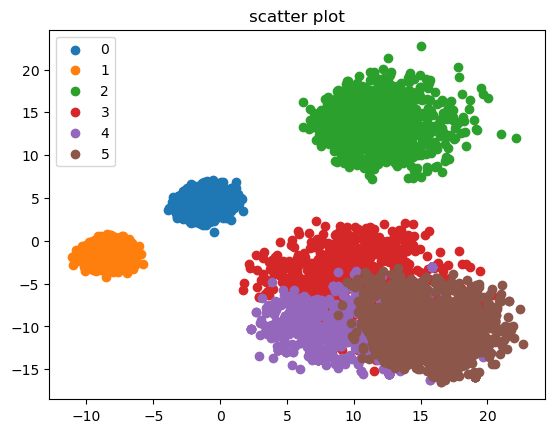

In [30]:
# plot
for i in range(CLUSTER_NUM):
    plt.scatter(
        subset_customer_df[subset_customer_df['cluster'] == i]['vector2dX'], 
        subset_customer_df[subset_customer_df['cluster'] == i]['vector2dY'], 
        label = i
    )
plt.legend()
plt.title('scatter plot')
plt.show()

We can see that clusters #3, #4 and #5 have some overlaps. This may be later furrther explored by comment samples from these clusters.

In [31]:
# write points
cluster_points_stat = []

with tqdm(total=len(subset_customer_df)) as pbar:
    for _, customer in subset_customer_df.iterrows():
        cluster_points_stat.append({
            'cluster': customer['cluster'],
            'x': customer['vector2dX'],
            'y': customer['vector2dY'],
        })
        pbar.update(1)

100%|██████████| 6000/6000 [00:00<00:00, 8587.47it/s]


In [32]:
with open(os.path.join(output_base_dir, 'cluster_points.json'), 'w') as f:
    json.dump(cluster_points_stat, f, cls=NpEncoder)

In [34]:
# sample from clusters
customer_cluster_stat = []
thresholds = [1, 10, 100, 1000, 10000]

with tqdm(total=CLUSTER_NUM) as pbar:
    for i in range(CLUSTER_NUM):
        subset_df = customer_df[customer_df['cluster']==i]
        count = len(subset_df)
        print(f'{count} customers in cluster #{i}, accounts for {100*count/total_count:.2f}%')
        comments = []
        for j in range(COMMENT_SAMPLE_N):
            comments.append(comment_df[comment_df['customerId']==subset_df.iloc[j]['customerId']].iloc[0])
        subset_comment_df = pd.DataFrame(comments, columns=comment_df.columns)
        customer_cluster_stat.append({
            'cluster': i,
            'count': count,
            'samples': parse_joined_comments_to_json(subset_comment_df)
        })
        pbar.update(1)
    

  0%|          | 0/6 [00:00<?, ?it/s]

1575872 customers in cluster #0, accounts for 41.96%


 17%|█▋        | 1/6 [00:35<02:56, 35.25s/it]

1404355 customers in cluster #1, accounts for 37.40%


 33%|███▎      | 2/6 [01:12<02:24, 36.19s/it]

187219 customers in cluster #2, accounts for 4.99%


 50%|█████     | 3/6 [01:50<01:51, 37.33s/it]

160936 customers in cluster #3, accounts for 4.29%


 67%|██████▋   | 4/6 [02:27<01:14, 37.07s/it]

179575 customers in cluster #4, accounts for 4.78%


 83%|████████▎ | 5/6 [03:01<00:35, 35.88s/it]

247377 customers in cluster #5, accounts for 6.59%


100%|██████████| 6/6 [03:38<00:00, 36.39s/it]


In [36]:
print(json.dumps(customer_cluster_stat, indent=4, cls=NpEncoder))

[
    {
        "cluster": 0,
        "count": 1575872,
        "samples": [
            {
                "summary": "Be a mensch and put something in that keppe!",
                "review": "Really an interesting and fun flick",
                "timestamp": 1443139200,
                "rating": 4.0,
                "sentiment": 0.4,
                "overall": 7.5,
                "wordCount": 6,
                "customer": {
                    "customerId": "A1O4NL9FRFNM9Q",
                    "name": "Yaniv C.",
                    "cluster": 0
                },
                "product": {
                    "asin": "B00UOB45DI",
                    "title": "Deli Man",
                    "brand": "Jerry Stiller",
                    "imageUrl": null,
                    "price": 24.99,
                    "categories": [
                        "Studio Specials",
                        "Sony Pictures Home Entertainment",
                        "All Sony Pictures Titles"
   

We may summarize the characteristics of each cluster:

- Cluster #0: The comments are polarized. The customers are very emotional: they tend to either call it the best or the worst.
- Cluster #1: It seems to me that this cluster focuses more on dramatic level, like plot and deep meaning, instead of visual wonder.
- Cluster #2: They follow blockkbusters, whether it's TV or movie. Recommendation on latest trend on them would make no mistake.
- Cluster #3: As opposed to the last cluster, they dig in for classics.
- Cluster #4: They concentrate on family friendly movies/shows, like cartoons, PG rated films, etc. Perhaps they have kids, or are teachers.
- Cluster #5: These customers purchase more adult-oriented movies/shows.

In [37]:
with open(os.path.join(output_base_dir, 'clusters.json'), 'w') as f:
    json.dump(customer_cluster_stat, f, cls=NpEncoder)